In [1]:
using Pkg
using Revise

Pkg.activate("..")

# Pkg.update("FoodWebs")

using CairoMakie
using NetworkLayout
using GraphMakie, Graphs, MetaGraphs
using ColorSchemes

using FoodWebs
using LinearAlgebra
using StatsBase, Polynomials
using JLD2

using ProfileVega


fw = FoodWebs

  Activating project at `~/Projects/Working/HIFMB/TempRanges`
[ Info: Precompiling CairoMakie [13f3f980-e62b-5c42-98c6-ff1f3baf88f0]
[ Info: Precompiling GraphMakie [1ecd5474-83a3-4783-bb4f-06765db800d2]
[ Info: Precompiling FoodWebs [eb5e2042-3c7d-468c-9da2-348e0f8d9fea]
[ Info: Precompiling Polynomials [f27b6e38-b328-58d1-80ce-0feddd5e7a45]


FoodWebs

# Introduction

In this notebook I will outline the simulation steps looking at the effects of shifts in species ranges with climate change. First I will describe the simulation procedure and then show some results. 

# Methods

Simulations are done as follows:

1. Generate a global pool of species with traits for body size $n$ and a thermal preference $0 < T_{pk} < 1$
2. Assemble $M$ stable communties using the niche model to generate their structure and the generalised modeling approach to ensure the proportion of stable webs (psw) is above some threshold. Each community has a temperature value $T$ and species are sampled so they are within some range of their respecitve preaks $T_{\text{range}}$.
3. Disperse species between communties according to one of two methods:
    1.  __Weighted__: Species disperse with a probability proportional to their body size $p_{d,i}(d) \propto n_i$. The communtiy to disperse to is sampled by weighting all communties with $e^{-2\lambda_i T_{\text{diff}}}$ where $T_{\text{diff}}$ is the difference in temperature between the two communties and $\lambda_i = (1 - n)^{0.75}$ is determined by body size. 
    2. __Random__: Species are selected randomly and disperse to all other communtities with uniform probability.

In [263]:
#1) GENERATE SPECIES POOL
N_pool = 25
@time sp_vec = fw.species(0.1, N_pool);

  0.000144 seconds (13 allocations: 3.484 KiB)


In [273]:
using Distributions

function exp_parameters(N::Int64, M::Int64)
    #exponent
    γ = rand(Uniform(0.75, 1.5), N, M) #[0.8, 1.5]
    λ = ones(N,N) # 1
    μ = rand(Uniform(1.0, 2.0), N, M) #[1.0, 2.0] 
    ϕ = rand(Uniform(0.0, 1.0), N, M) #[0.0, 1.0]
    ψ = rand(Uniform(0.25,1.25), N, M) #[0.5, 1.2]

    return [fw.ExponentialParameters(γ[:,i], λ, μ[:,i], ϕ[:,i], ψ[:,i]) for i = 1:M]
end

random_parameters(com::fw.Community, M::Int64) = random_parameters(com.N, M)

random_parameters (generic function with 2 methods)

In [274]:
Nrep = 200
psw = zeros(Nrep)
coms = Array{fw.Community, 1}(undef, Nrep)
for i = 1:Nrep
    sp_vec = fw.species(0.2, N_pool,n = rand(N_pool));
    coms[i] = fw.community(sp_vec)
    psw[i] = fw.proportion_stable_webs(coms[i], N_trials = 100, f_ep = random_parameters)
end

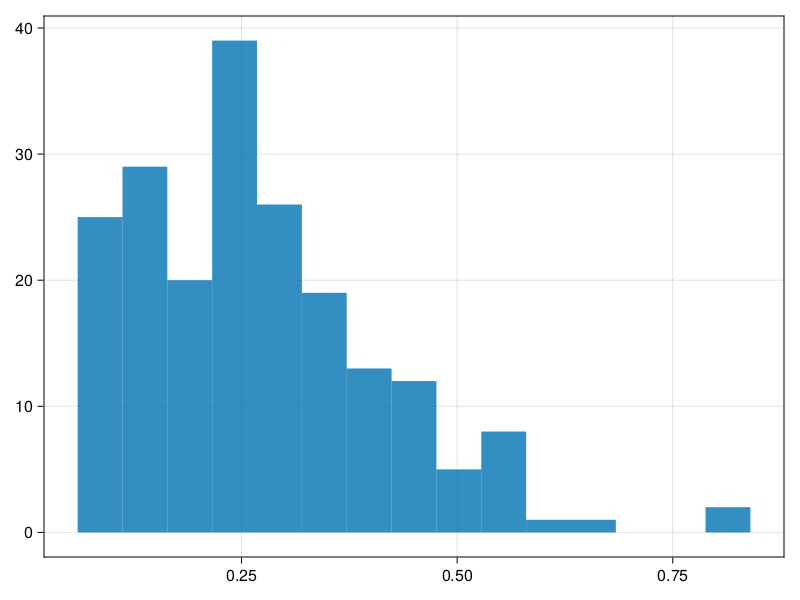

In [275]:
hist(psw)

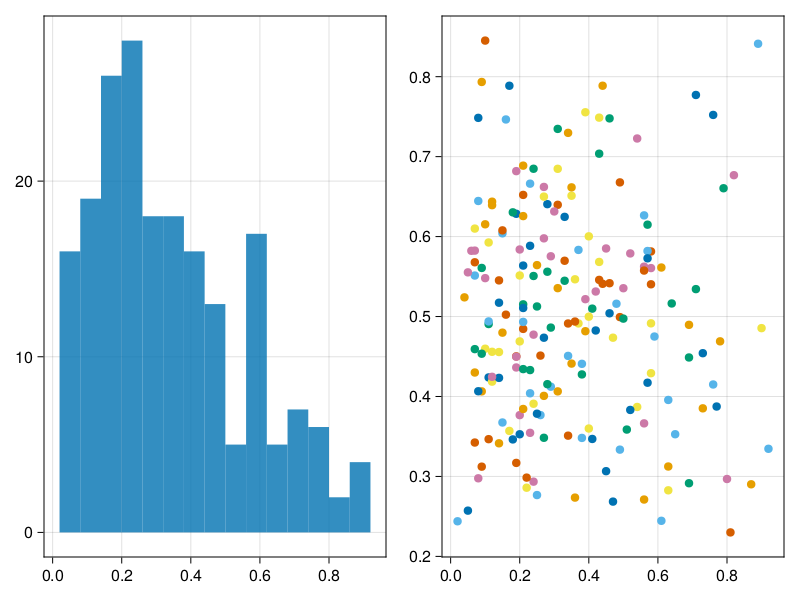

In [5]:
fig = Figure()
ax = Axis(fig[1,1])
hist!(ax, psw)

ax = Axis(fig[1,2])
for i = 1:Nrep
    scatter!(ax, fill(psw[i],1), [median(coms[i].n)], width = 0.01, orientation = :horizontal)
end

fig

In [20]:
max_indx = findmax(psw)[2]
max_com = deepcopy(coms[max_indx])
sp_list = deepcopy(max_com.sp)

psw = fw.proportion_stable_webs(max_com, N_trials = 1000)
Δpsw = zeros(N_pool)
#itterate through removals
for i = 1:N_pool
    to_rm = deepcopy(coms[max_indx].sp[i])
    
    max_com = fw.remove_species(max_com, to_rm.id)
    
    Δpsw[i] = fw.proportion_stable_webs(max_com, N_trials = 1000)
    
    max_com = fw.add_species(max_com, to_rm)
    
end


In [21]:
using Random

# Random.seed!()

#2) ASSEMBLE COMMUNITIES
#set temperatures
N_T = 50
t_vec = range(0,1,length = N_T)

@time mc = fw.stable_metacommunity(10, 0.1, t_vec, T_range = 0.2, R = 43.0, psw_threshold = 0.8, verbose = true, max_draws = 30000, N_trials = 50)
@time psw_a = fw.proportion_stable_webs(mc, N_trials = 200);

mc_origin = deepcopy(mc)

draw:0 psw: [0.82, 0.88, 0.64, 0.48, 0.58, 0.86, 0.62, 0.78, 0.78, 0.76, 0.8, 0.36, 0.64, 0.4, 0.78, 0.7, 0.78, 0.46, 0.68, 0.78, 0.9, 0.7, 0.72, 0.96, 0.52, 0.98, 0.56, 0.5, 0.46, 0.52, 0.9, 0.88, 0.94, 0.66, 0.72, 0.74, 0.74, 0.3, 0.8, 0.74, 0.68, 0.88, 0.24, 0.02, 0.62, 0.48, 0.5, 0.76, 0.92, 0.42]
draw:5 psw: [0.82, 0.88, 0.7, 0.86, 0.86, 0.86, 0.94, 0.82, 0.8, 0.96, 0.8, 0.86, 0.86, 0.96, 0.28, 0.84, 0.8, 0.9, 0.86, 0.78, 0.9, 0.8, 0.48, 0.96, 0.8, 0.98, 0.86, 1.0, 0.9, 0.94, 0.9, 0.88, 0.94, 0.88, 0.92, 0.62, 0.3, 0.82, 0.8, 0.88, 0.84, 0.88, 0.86, 0.84, 0.94, 0.82, 0.96, 0.76, 0.92, 0.9]
  0.115458 seconds (150.32 k allocations: 43.107 MiB)
  0.099474 seconds (162.30 k allocations: 48.970 MiB)


MetaCommunity M:50 FoodWebs.Community Sp: 500

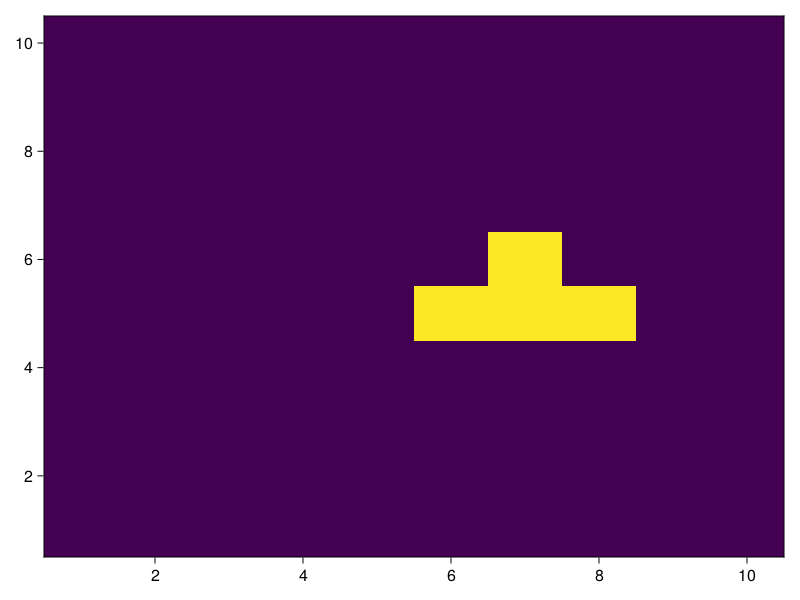

In [22]:
#plot interaction matrix of a community
c = mc.coms[2]
indx = sortperm(c.n)
heatmap(c.A[indx, indx])

In [31]:
#dispersal 
Nrep = 1

psw_b = zeros(N_T, Nrep)

mc = deepcopy(mc_origin)
a = [42 .^ mc.coms[1].n for i = 1:N_T];
fw.multiple_dispersal!(mc, p_dispersal = :p, d_dispersal = :p)
b = [42 .^ mc.coms[1].n for i = 1:N_T];
psw_b[:, 1] = fw.proportion_stable_webs(mc, N_trials= 100);


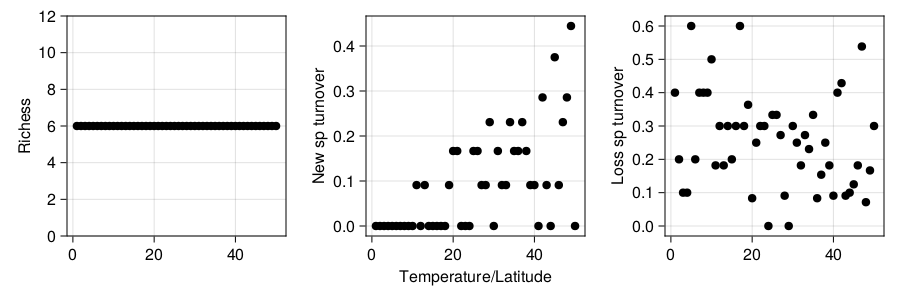

In [32]:
fig = Figure(resolution = (900,300))

#richness
ax1 = Axis(fig[1,1], ylabel = "Richess")
N = length.(b)
plot!(ax1, 1:N_T, N)

#turnover
function jacc(id1,id2; method = :total)
    if method == :total
        return(length(intersect(id1,id2)) / length(union(id1,id2)))
    elseif method == :new
        return( sum(.!in.(id1, Ref(id2))) / length(union(id1,id2)) )
    elseif method == :out
        return( sum(.!in.(id2, Ref(id1))) / length(union(id1,id2)) )
    end
end

ax2 = Axis(fig[1,2],xlabel = "Temperature/Latitude", ylabel = "New sp turnover")
j = [jacc(mc.coms[T].ids, mc_origin.coms[T].ids, method = :new) for T = 1:N_T]
plot!(ax2, j)

ax3 = Axis(fig[1,3], ylabel = "Loss sp turnover")
j = [jacc(mc.coms[T].ids, mc_origin.coms[T].ids, method = :out) for T = 1:N_T]
plot!(ax3, j)

fig

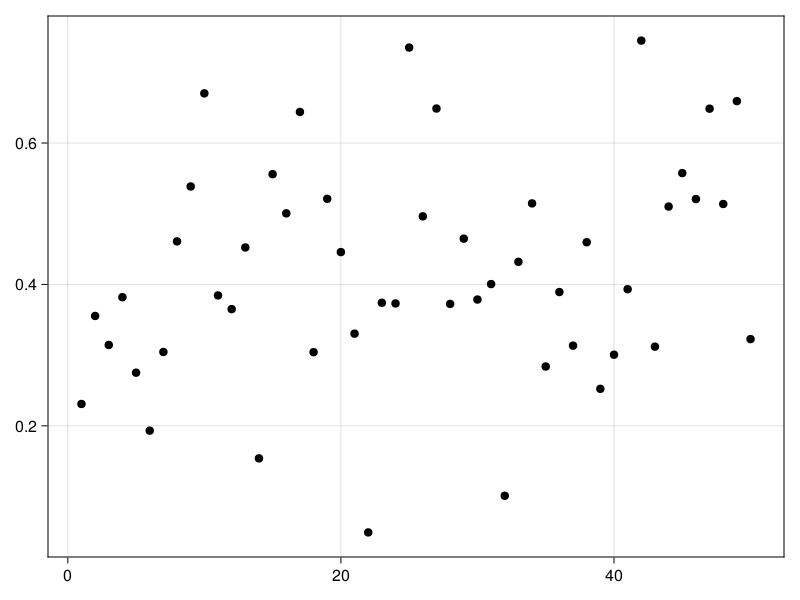

In [33]:
plot([median(c.n) for c = mc.coms])

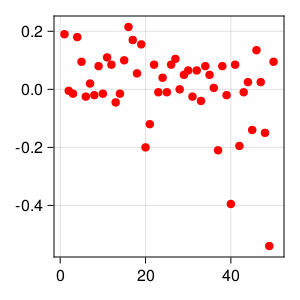

In [34]:
fig = Figure(resolution = (300,300))
ax = Axis(fig[1,1])
# scatter!(ax, 1:N_T, , color = :black)
scatter!(ax, 1:N_T, psw_b[:] .- psw_a[:], color = :red)
fig

In [35]:
psw_b

50×1 Matrix{Float64}:
 1.0
 0.9
 0.81
 0.94
 0.94
 0.78
 1.0
 0.73
 0.81
 0.92
 0.86
 0.97
 0.83
 ⋮
 0.8
 0.51
 0.86
 0.71
 0.85
 0.88
 0.65
 0.84
 0.93
 0.74
 0.29
 0.99

In [36]:
#3) DISPERSAL
# # FoodWebs.K_dispersals!(mc1,10)
# N_dispersal = 2
# N_rep = 100
# N_trials = 10

# res = zeros(N_T, N_dispersal,N_rep,2,N_trials)
# params = Array{fw.GeneralisedParameters, 5}(undef, N_T, N_dispersal,N_rep,2,N_trials)
# bodysize = Array{Vector{Float64},4}(undef, N_T, N_dispersal,N_rep,2)

# Threads.@threads for r = 1:N_rep
#     mc_prob,mc_random = generate_mc(sp_vec)
    
#     for d = 1:N_dispersal
#         #probabablistic
#         for (i,c) = enumerate(mc_prob.coms)
#             #itterate for given web structure
#             for trial = 1:N_trials
#                 p = fw.generalised_parameters(c)
#                 J = similar(p.A)
#                 fw.generalised_jacobian!(J,p)
#                 res[i,d,r,1,trial] = fw.max_real_eigval(J) 
#                 params[i,d,r,1,trial] = deepcopy(p)
#             end
#         end
        
#         #random
#         for (i,c) = enumerate(mc_random.coms)
#             #itterate for given web structure
#             for trial = 1:N_trials
#                 p = fw.generalised_parameters(c)
#                 J = similar(p.A)
#                 fw.generalised_jacobian!(J,p)
#                 res[i,d,r,2,trial] = fw.max_real_eigval(J) 
#                 params[i,d,r,2,trial] = deepcopy(p)
#             end
#         end
        
#         bodysize[:,d,r,1] .= get_M.(mc_prob.coms)
#         bodysize[:,d,r,2] .= get_M.(mc_random.coms)


#         fw.multiple_dispersal!(mc_prob, p_dispersal = :p, d_dispersal = :p)
#         fw.multiple_dispersal!(mc_random, p_dispersal = :r, d_dispersal = :r)

#         if d % 100 == 0
#             print(i)
#         end
#     end
# end

# # save("simulations.jld2", Dict("res" => res, "params" => params, "bodysize" => bodysize))

In [223]:
r = load("../Data/psw_test/simulations_1_1_1.jld2")

Dict{String, Any} with 4 entries:
  "vecs"     => [#undef #undef … #undef #undef; #undef #undef … #undef #undef; …
  "vals"     => [#undef #undef … #undef #undef; #undef #undef … #undef #undef; …
  "bodysize" => [[5.58201, 2.95919, 39.749, 18.3612, 4.83208, 1.53996, 1.29107,…
  "psw"      => [0.02 0.0 … 0.0 0.0; 0.04 0.02 … 0.0 0.02; … ; 0.0 0.0 … 0.04 0…

In [224]:
N_T = size(r["psw"])[1]
N_rep = size(r["psw"])[2]

10

# Results

Here we have the results from the simulations. Across the communties we see a clear pattern of stability in the allometric (i.e. constrained) and the random dispersal. 

The allometric generally shows reduced stability at higher lattitudes presumably because of the influx more species.

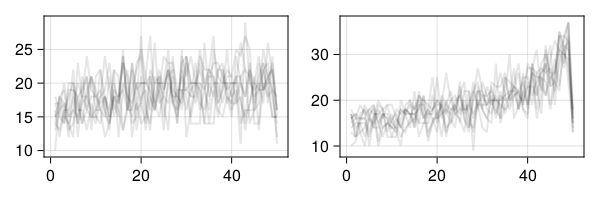

In [225]:
#richness
N_res = length.(r["bodysize"])

fig = Figure(resolution = (600,200))
ax = Axis(fig[1,1])
series!(ax, N_res[:,:,1,2]', solid_color = (:black, 0.1))

ax = Axis(fig[1,2])
series!(ax, N_res[:,:,2,2]', solid_color = (:black, 0.1))


fig

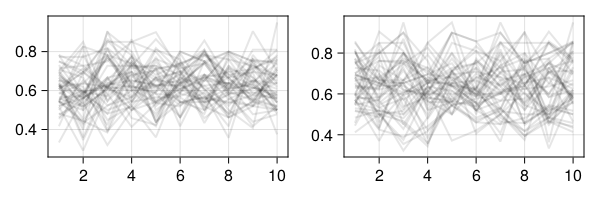

In [226]:
#turnover - use bs as proxy for now
res_bs = r["bodysize"]
turnover = zeros(N_T, N_rep, 2)

for r = 1:N_rep
    for p = 1:2
        turnover[:,r,p,1] .= [jacc(res_bs[T,r,p,1], res_bs[T,r,p,2], method = :total) for T = 1:N_T]
    end
end

fig = Figure(resolution = (600,200))

ax = Axis(fig[1,1])
series!(ax, turnover[:,:,1], solid_color = (:black, 0.1))

ax = Axis(fig[1,2])
series!(ax, turnover[:,:,2], solid_color = (:black, 0.1))

fig

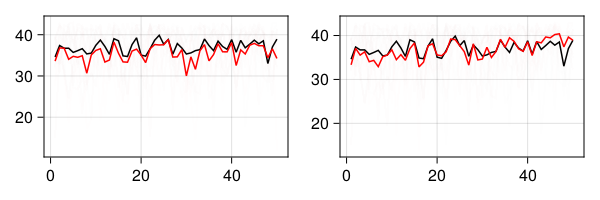

In [227]:
#bodysize
fixmax(x) = length(x) > 0 ? maximum(x) : NaN

bs_res = fixmax.(r["bodysize"])
bs_max = mapslices(x -> mean(filter(!isnan,x)), bs_res, dims = 2)

fig = Figure(resolution = (600,200))
ax = Axis(fig[1,1])
series!(ax, bs_res[:,:,1,1]', solid_color = (:black, 0.005))
lines!(ax,1:N_T, bs_max[:,1,1,1], color = :black)

series!(ax, bs_res[:,:,1,2]', solid_color = (:red, 0.005))
lines!(ax,1:N_T, bs_max[:,1,1,2], color = :red)

ax = Axis(fig[1,2])
series!(ax, bs_res[:,:,2,1]', solid_color = (:black, 0.005))
lines!(ax,1:N_T, bs_max[:,1,2,1], color = :black)

series!(ax, bs_res[:,:,2,2]', solid_color = (:red, 0.005))
lines!(ax,1:N_T, bs_max[:,1,2,2], color = :red)

linkaxes!.(fig.content)

fig


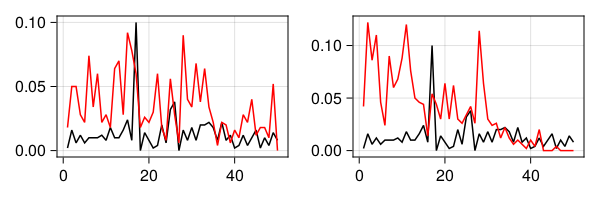

In [228]:
#bodysize
psw_res = r["psw"]

fig = Figure(resolution = (600,200))
ax = Axis(fig[1,1])
# series!(ax, psw_res[:,:,1,1]', solid_color = (:black, 0.001))
lines!(ax,1:N_T, mean(psw_res, dims = 2)[:,1,1,1], color = :black)

# series!(ax, psw_res[:,:,1,2]', solid_color = (:red, 0.001))
lines!(ax,1:N_T, mean(psw_res, dims = 2)[:,1,1,2], color = :red)


ax = Axis(fig[1,2])
# series!(ax, psw_res[:,:,2,1]', solid_color = (:black, 0.001))
lines!(ax,1:N_T, mean(psw_res, dims = 2)[:,1,2,1], color = :black)

# series!(ax, psw_res[:,:,2,2]', solid_color = (:red, 0.001))
lines!(ax,1:N_T, mean(psw_res, dims = 2)[:,1,2,2], color = :red)

fig

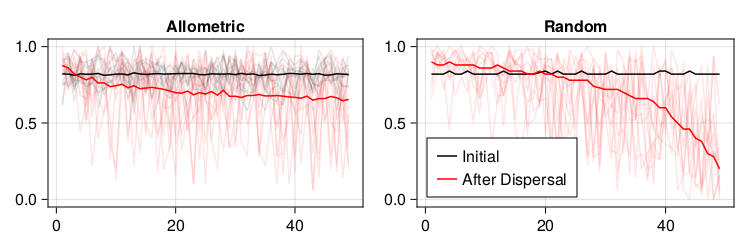

In [133]:
f = Figure(resolution=(750,250))
ax1 = Axis(f[1,1], title = "Allometric")

N_rep = 10
T_lim = 1:(N_T-1)

psw = r["psw"]

for r = 1:N_rep
        lines!(ax1, T_lim, psw[T_lim,r,1,1], color = ("black", 0.1))
        lines!(ax1, T_lim, psw[T_lim,r,1,2], color = ("red", 0.1))
end

lines!(ax1, T_lim, mean(psw,dims=2)[T_lim,1,1,1], color = "black")
lines!(ax1, T_lim, mean(psw,dims=2)[T_lim,1,1,2], color = "red")


ax2 = Axis(f[1,2], title = "Random")

for r = 1:N_rep
        lines!(ax2, T_lim, psw[T_lim,r,2,1], color = ("black", 0.0))
        lines!(ax2, T_lim, psw[T_lim,r,2,2], color = ("red", 0.1))
end

lines!(ax2, T_lim, median(psw,dims=2)[T_lim,1,2,1], color = "black", label = "Initial")
lines!(ax2, T_lim, median(psw,dims=2)[T_lim,1,2,2], color = "red", label = "After Dispersal")

axislegend(ax2,position = :lb)

linkyaxes!(ax1,ax2)


f

In [143]:
real.(r["vals"][1,1,1,2])

50-element Vector{Float64}:
 -0.34312963916664513
 -0.595888092457547
 -0.15725461000391444
 -0.1990863532748335
 -0.23465451241102836
 -0.6292950161406158
 -0.2202321430222964
 -0.3221767376339317
 -0.12790091920504257
 -0.2576764461152772
 -0.6873094631247478
 -0.49366508055900055
 -0.31989829284818644
  ⋮
 -0.21015589605185306
 -0.6676487724034328
 -0.16247643860818908
 -0.11959676875391027
 -0.24208155792175248
 -0.19741095514875137
 -0.33904755927538577
 -0.2214517291655263
 -0.4578457229482825
 -0.077861186304753
 -0.206640215454646
 -0.2610162934942749

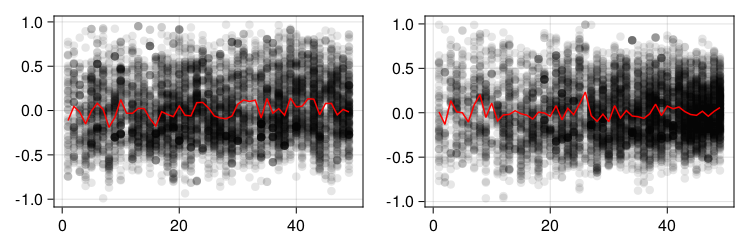

In [220]:
#types of instability
cor_mat = fill(Float64[], N_T-1, N_rep, 2)

for i = 1:2
    for T = T_lim
        for rep = 1:N_rep
            #get values
            λvals = real.(r["vals"][T,rep,i,2])

            unstable = findall(λvals .>= 0)

            if length(unstable) > 0
                unstable_vecs = norm.(r["vecs"][T,rep,i,2][unstable, :])
                bs_vec = r["bodysize"][T,rep,i,2]

                cor_mat[T,rep,i] = mapslices(x -> cor(x,bs_vec) , unstable_vecs, dims = 2)[:]
            end
        end
    end
end

fig = Figure(resolution = (750,250))
ax1 = Axis(fig[1,1])
ax2 = Axis(fig[1,2])

for T = T_lim
    for rep = 1:N_rep
        if length(cor_mat[T,rep,1]) > 0
            scatter!(ax1, fill(T, length(cor_mat[T,rep,1])), cor_mat[T,rep,1], color = (:black, 0.1))
        end
        
         if length(cor_mat[T,rep,2]) > 0
            scatter!(ax2, fill(T, length(cor_mat[T,rep,2])), cor_mat[T,rep,2], color = (:black, 0.1))
        end
        
    end
end

cor_mean = map(x -> mean(filter(!isnan,x)), cor_mat)
cor_mean = mapslices(x -> mean(filter(!isnan,x)), cor_mean, dims = 2)

lines!(ax1, T_lim, cor_mean[:,1,1], color = "red")
lines!(ax2, T_lim, cor_mean[:,1,2], color = "red")

fig

# Foodweb Plotting

In [221]:
function foodweb_layout(g)
    ny = 1 .- g.gprops[:n]
    nx = rand(length(g.gprops[:n]))
    return(Point.(zip(nx, ny)))
end

foodweb_layout (generic function with 1 method)

In [222]:
#plotting
stable_coms = [communities[i,x[2]] for (i,x) = enumerate(stable_indx)]

#convert to graphs
g_vec = Vector{Any}(undef, N_temp)
for (i,sc) = enumerate(stable_coms)
    g = MetaDiGraph(SimpleDiGraph(sc.A))
    set_prop!(g, :n, [x.n for x = sc.sp])
    
    g_vec[i] = g
end

LoadError: UndefVarError: stable_indx not defined

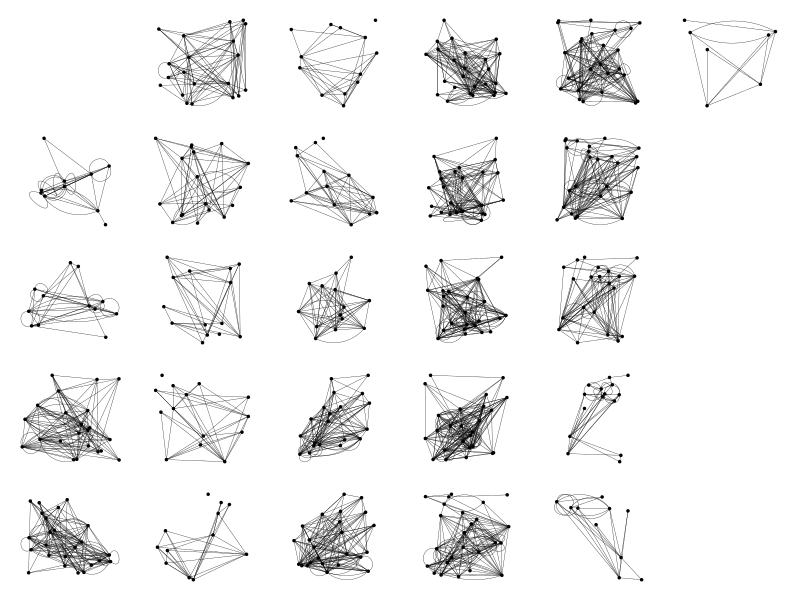

In [53]:
f = Figure()

ax = [Axis(f[i % 5,(i ÷ 5)]) for i = 1:N_temp]

[graphplot!(ax[i],g_vec[i], layout=foodweb_layout, edge_width = 0.3, arrow_size = 0.0, node_size = 5) for i = 1:N_temp]
hidedecorations!.(ax); hidespines!.(ax)
[ax[i].aspect = DataAspect() for i = 1:N_temp]

f

In [54]:
#calculate sp_occurance
result = Vector{Any}(undef, length(sp_vec))
id_sp = Dict{Base.UUID,Vector{Any}}()

for i = CartesianIndices(stable_coms)
    for s = communities[i].sp
        if s.id in keys(id_sp)
            push!(id_sp[s.id], i)
        else
            id_sp[s.id] = [i]
        end
    end
end
